# Clustering on Open Food Facts dataset

### Load data

In [1]:
# Imports libraries
import pandas as pd
import numpy as np
# import mlflow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# import umap
%matplotlib inline
import matplotlib.pyplot as plt

# Pre-process
from scripts.clean import analyse_columns, clean

# Kmeans
from scripts.kmeans.kmeans import find_elbow_point
from scripts.kmeans.kmeans import kmeans_clustering, analyze_clusters

# from scripts.kmeans.kmeans import kmeans_clustering, plot_elbow_method

# Dim reduction

# HDBSCAN
from scripts.hdbscan.hdbscan import hdbscan_clustering, analyze_clusters, plot_cluster_probabilities

# Autoencoders
# from scripts.autoencoders.autoencoder import autoencoder_clustering, plot_autoencoder_advanced_analysis, analyze_encoding_dimensions

# from scripts.utils.plots import plot_clusters_2d, plot_cluster_sizes, plot_feature_relationships
# from scripts.utils.model_utils import load_model

# mlflow.autolog()

: 

In [3]:
# Load Open Food Facts dataset csv
path = "data/en.openfoodfacts.org.products.csv"

df = pd.read_csv(path, 
                 sep='\\t', 
                 encoding="utf-8",
                 on_bad_lines='skip',
                 nrows=300000)

C:\Users\jaech\AppData\Local\Temp\ipykernel_15516\4190858480.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path,


In [3]:
# Display basic information about the dataset
print("\nFirst few rows:")
display(df.head())


First few rows:


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,54,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1733085204,2024-12-01T20:33:24Z,NaN,1.740205e+09,2025-02-22T06:23:42Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1673620307,2023-01-13T14:31:47Z,1739902555,2025-02-18T18:15:55Z,waistline-app,1.740360e+09,2025-02-24T01:26:17Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1737247862,2025-01-19T00:51:02Z,smoothie-app,1.740075e+09,2025-02-20T18:10:18Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1742247341,2025-03-17T21:35:41Z,roboto-app,1.742247e+09,2025-03-17T21:35:41Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1572117743,2019-10-26T19:22:23Z,1738073570,2025-01-28T14:12:50Z,NaN,1.740085e+09,2025-02-20T20:57:12Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Display number of rows and columns
print(df.shape)

(300000, 206)


In [5]:
# Show summary statistics of numeric columns
# Display detailed summary statistics of numeric columns
print("\nSummary statistics of numeric columns:")
print(df.describe(include=[np.number], percentiles=[.05, .25, .5, .75, .95]))

# Show additional statistics
print("\nSkewness of numeric columns:")
print(df.select_dtypes(include=[np.number]).skew())

print("\nKurtosis of numeric columns:")
print(df.select_dtypes(include=[np.number]).kurtosis())

# Count number of non-null values for each numeric column
print("\nNumber of non-null values in numeric columns:")
print(df.select_dtypes(include=[np.number]).count())


Summary statistics of numeric columns:
               code     created_t  last_modified_t  last_updated_t  cities  \
count  3.000000e+05  3.000000e+05     3.000000e+05    2.999990e+05     0.0   
mean   3.142524e+10  1.602130e+09     1.675095e+09    1.729909e+09     NaN   
std    1.793752e+10  7.930433e+07     6.009212e+07    1.253325e+07     NaN   
min    1.000000e+00  1.332445e+09     1.424628e+09    1.701775e+09     NaN   
5%     3.759174e+05  1.489060e+09     1.587584e+09    1.707823e+09     NaN   
25%    1.590006e+10  1.537557e+09     1.627272e+09    1.720271e+09     NaN   
50%    3.594086e+10  1.592158e+09     1.685832e+09    1.734786e+09     NaN   
75%    4.222285e+10  1.660253e+09     1.728054e+09    1.738830e+09     NaN   
95%    5.974995e+10  1.726604e+09     1.740367e+09    1.740367e+09     NaN   
max    6.263938e+10  1.742962e+09     1.742967e+09    1.742967e+09     NaN   

       allergens_en  serving_quantity    additives_n  additives  \
count           0.0      1.738320e

### Data Processing

In [6]:
# Keep only relevant columns (nutritional columns)

# Define features to keep
features = [
    'energy-kcal_100g', 'energy_100g',
    'fat_100g', 'saturated-fat_100g',
    'carbohydrates_100g', 'sugars_100g', 
    'fiber_100g', 'proteins_100g',
    'salt_100g', 'sodium_100g',
    'fruits-vegetables-nuts-estimate-from-ingredients_100g',
    'additives_n',
    'nova_group'  # optional but relevant
]
# Update irrelevant_columns to be columns not in features
irrelevant_columns = [col for col in df.columns if col not in features]

# Manually remove energy-kcal_100g and fat_100g from irrelevant_columns
# irrelevant_columns.extend(['energy-kcal_100g', 'fat_100g'])


# Clean dataset using the clean() function
df_cleaned = clean.clean(df, irrelevant_columns=irrelevant_columns, missing_threshold=0.5)

# Display cleaned dataset info
print("\nCleaned dataset shape:", df.shape)
print("\nRemaining columns:")
print(df_cleaned.columns.tolist())



Cleaned dataset shape: (300000, 206)

Remaining columns:
['additives_n', 'nova_group', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


In [7]:
# Handle missing values by filling with median for numeric columns
# Using median instead of mean to be more robust to outliers
df_cleaned = df_cleaned.fillna(df_cleaned.median())

# Verify no more NaN values exist
print("\nNumber of NaN values remaining:")
print(df_cleaned.isna().sum().sum())

# Display first few rows to verify changes
print("\nFirst few rows after handling missing values:")
display(df_cleaned.head())

print("\nShape")
print(df_cleaned.shape)


Number of NaN values remaining:
0

First few rows after handling missing values:


,additives_n,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,1.0,4.0,270.0,1130.0,5.172414,1.5,22.988503,5.26,1.41,5.0,0.4325,0.173,0.670000
1,0.0,4.0,332.0,1389.0,25.000000,17.3,3.000000,1.00,1.41,23.0,1.2000,0.480,0.000000
2,1.0,4.0,270.0,2415.0,44.000000,28.0,30.000000,27.00,1.41,7.1,0.0250,0.010,0.670000
3,0.0,1.0,270.0,1130.0,5.172414,1.5,22.988503,5.26,1.41,5.0,0.4325,0.173,100.000000
4,2.0,4.0,270.0,1130.0,5.172414,1.5,22.988503,5.26,1.41,5.0,0.4325,0.173,0.011335



Shape
(300000, 13)


In [8]:
# Scale features using StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_cleaned),
    columns=df_cleaned.columns
)

# Display first few rows of scaled data
print("First few rows of scaled data:")
display(df_scaled.head())

# Verify scaling - mean should be ~0 and std should be ~1
print("\nMean of scaled features:")
print(df_scaled.mean().round(2))
print("\nStandard deviation of scaled features:")
print(df_scaled.std().round(2))

First few rows of scaled data:


,additives_n,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,-0.330752,0.358602,-0.133253,-0.132839,-0.234255,-0.128697,-0.241410,-0.276793,-0.061425,-0.167371,-0.001826,-0.001826,-0.397221
1,-0.737316,0.358602,-0.014850,-0.014526,0.226550,0.447083,-0.540333,-0.378692,-0.061425,0.624400,-0.001826,-0.001826,-0.425070
2,-0.330752,0.358602,-0.133253,0.454158,0.668122,0.837010,-0.136555,0.243229,-0.061425,-0.074998,-0.001826,-0.001826,-0.397221
3,-0.737316,-3.768056,-0.133253,-0.132839,-0.234255,-0.128697,-0.241410,-0.276793,-0.061425,-0.167371,-0.001826,-0.001826,3.731573
4,0.075812,0.358602,-0.133253,-0.132839,-0.234255,-0.128697,-0.241410,-0.276793,-0.061425,-0.167371,-0.001826,-0.001826,-0.424599



Mean of scaled features:
additives_n                                             -0.0
nova_group                                              -0.0
energy-kcal_100g                                         0.0
energy_100g                                              0.0
fat_100g                                                 0.0
saturated-fat_100g                                       0.0
carbohydrates_100g                                      -0.0
sugars_100g                                              0.0
fiber_100g                                               0.0
proteins_100g                                            0.0
salt_100g                                               -0.0
sodium_100g                                              0.0
fruits-vegetables-nuts-estimate-from-ingredients_100g   -0.0
dtype: float64

Standard deviation of scaled features:
additives_n                                              1.0
nova_group                                               1.0
ener

In [9]:
# Remove outliers using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for values within bounds
    mask = ~((df < lower_bound) | (df > upper_bound)).any(axis=1)
    
    return df[mask]

# Remove outliers and store in new DataFrame
print("Shape before removing outliers:", df_scaled.shape)
df_scaled_no_outliers = remove_outliers(df_scaled)
print("Shape after removing outliers:", df_scaled_no_outliers.shape)
print(f"Removed {df_scaled.shape[0] - df_scaled_no_outliers.shape[0]} outliers")

# Update original data without outliers for consistency
df_cleaned = df_cleaned.loc[df_scaled_no_outliers.index]

Shape before removing outliers: (300000, 13)
Shape after removing outliers: (117464, 13)
Removed 182536 outliers


### Feature Engineering

In [12]:
# Create new features


Taking a sample of 10000 rows for PCA visualization...
Performing PCA...
Explained variance ratio: [9.99081928e-01 5.97833288e-04]
Cumulative explained variance ratio: [0.99908193 0.99967976]
Creating visualization plots...


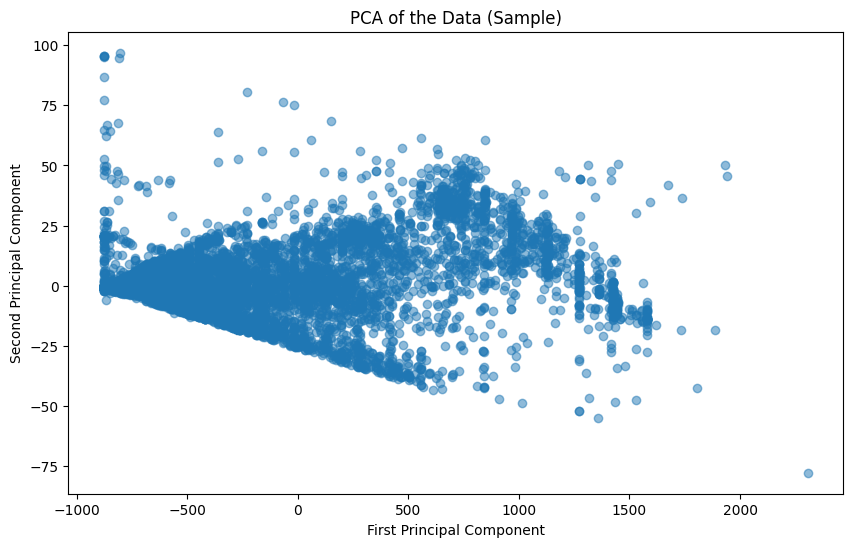

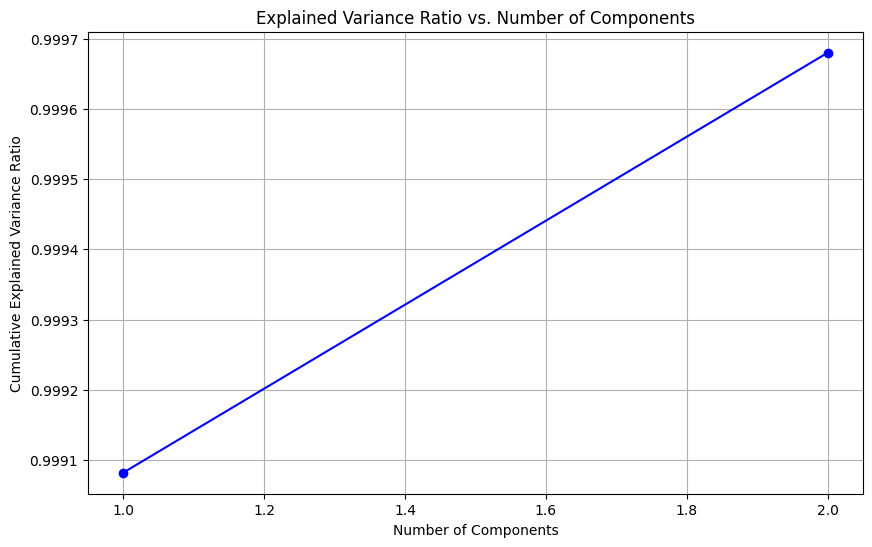

In [10]:
# Take a smaller sample for visualization (10,000 rows)
sample_size = 10000
print(f"Taking a sample of {sample_size} rows for PCA visualization...")
df_sample = df_cleaned.sample(n=sample_size, random_state=42)

# Initialize PCA with 2 components for visualization
print("Performing PCA...")
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_sample.values)

# Calculate explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', np.cumsum(pca.explained_variance_ratio_))

# Plot PCA results
print("Creating visualization plots...")
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of the Data (Sample)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [14]:
# Analyze feature importance and correlations


### Clustering Analysis

#### - K-Means

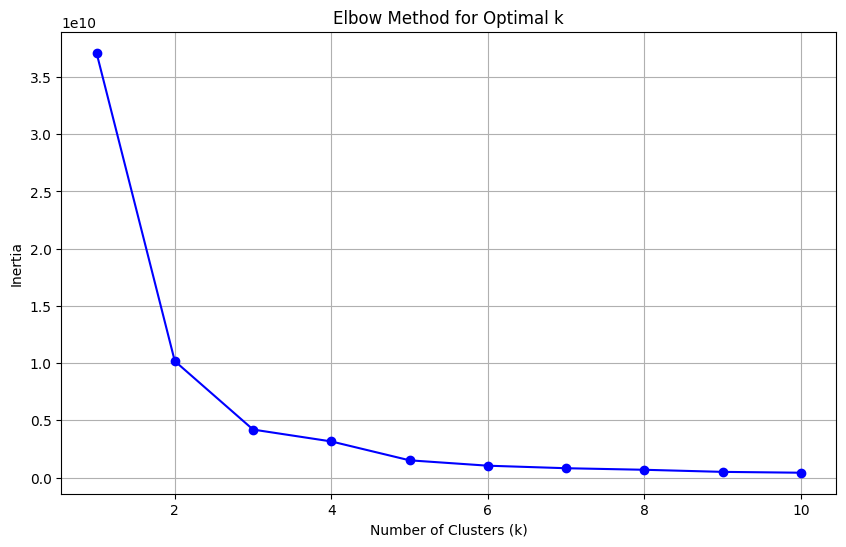

Optimal number of clusters (k) at elbow point: 3


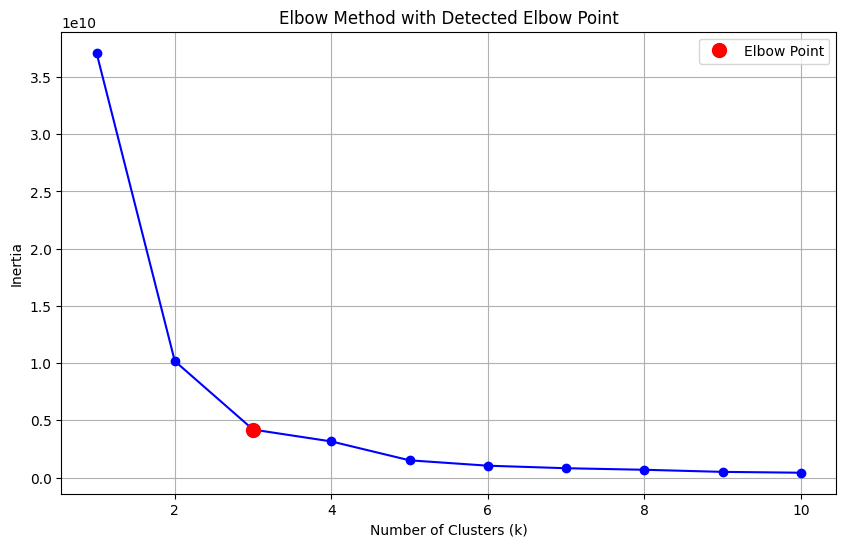

In [10]:
# Guess elbow

# Assuming df_scaled_no_outliers is your cleaned and scaled data
optimal_k = find_elbow_point(df_cleaned.values)

In [12]:
# Add Kmeans depending on the elbow
# Perform K-means clustering with optimal k
print("\nPerforming K-means clustering with optimal k...")
kmeans, labels, metrics = kmeans_clustering(df_cleaned.values, n_clusters=optimal_k)


Performing K-means clustering with optimal k...



Clustering metrics:
Inertia: 4196564671.35
Number of iterations: 4
Silhouette score: 0.720

Analyzing cluster characteristics...


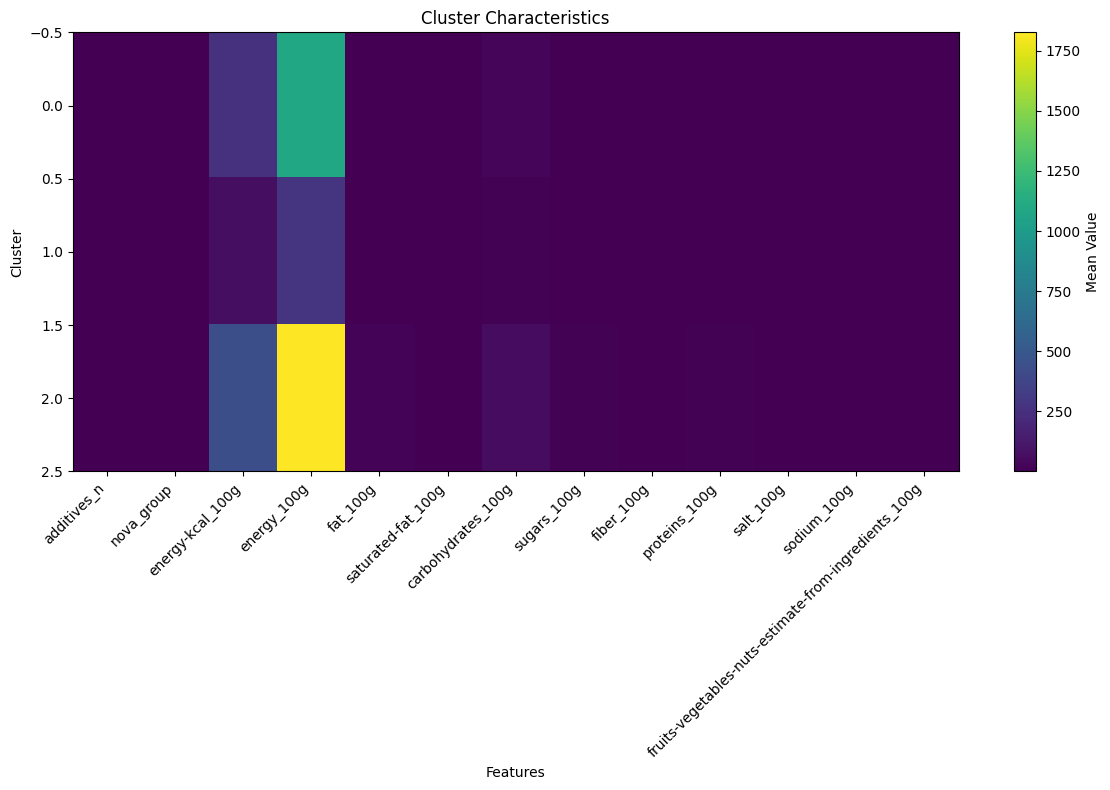


Cluster sizes:
Cluster 0: 58980 samples
Cluster 1: 45148 samples
Cluster 2: 13336 samples


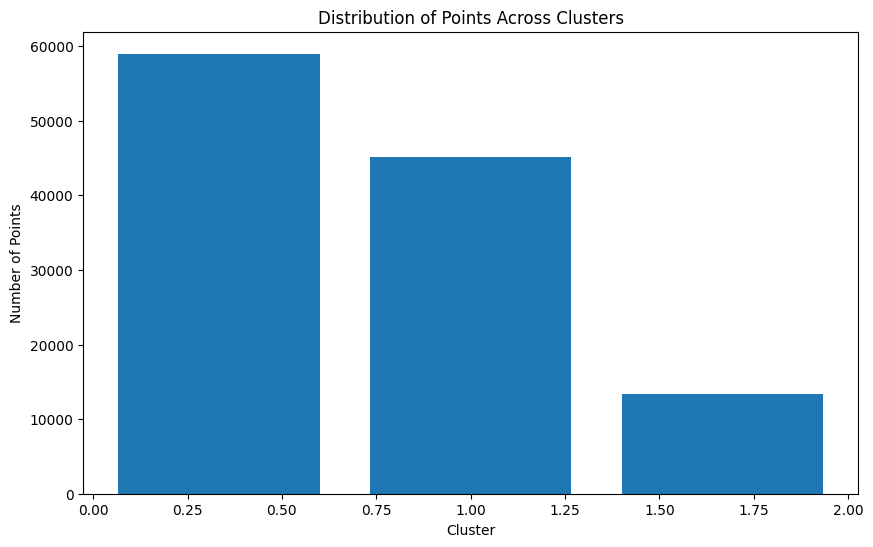

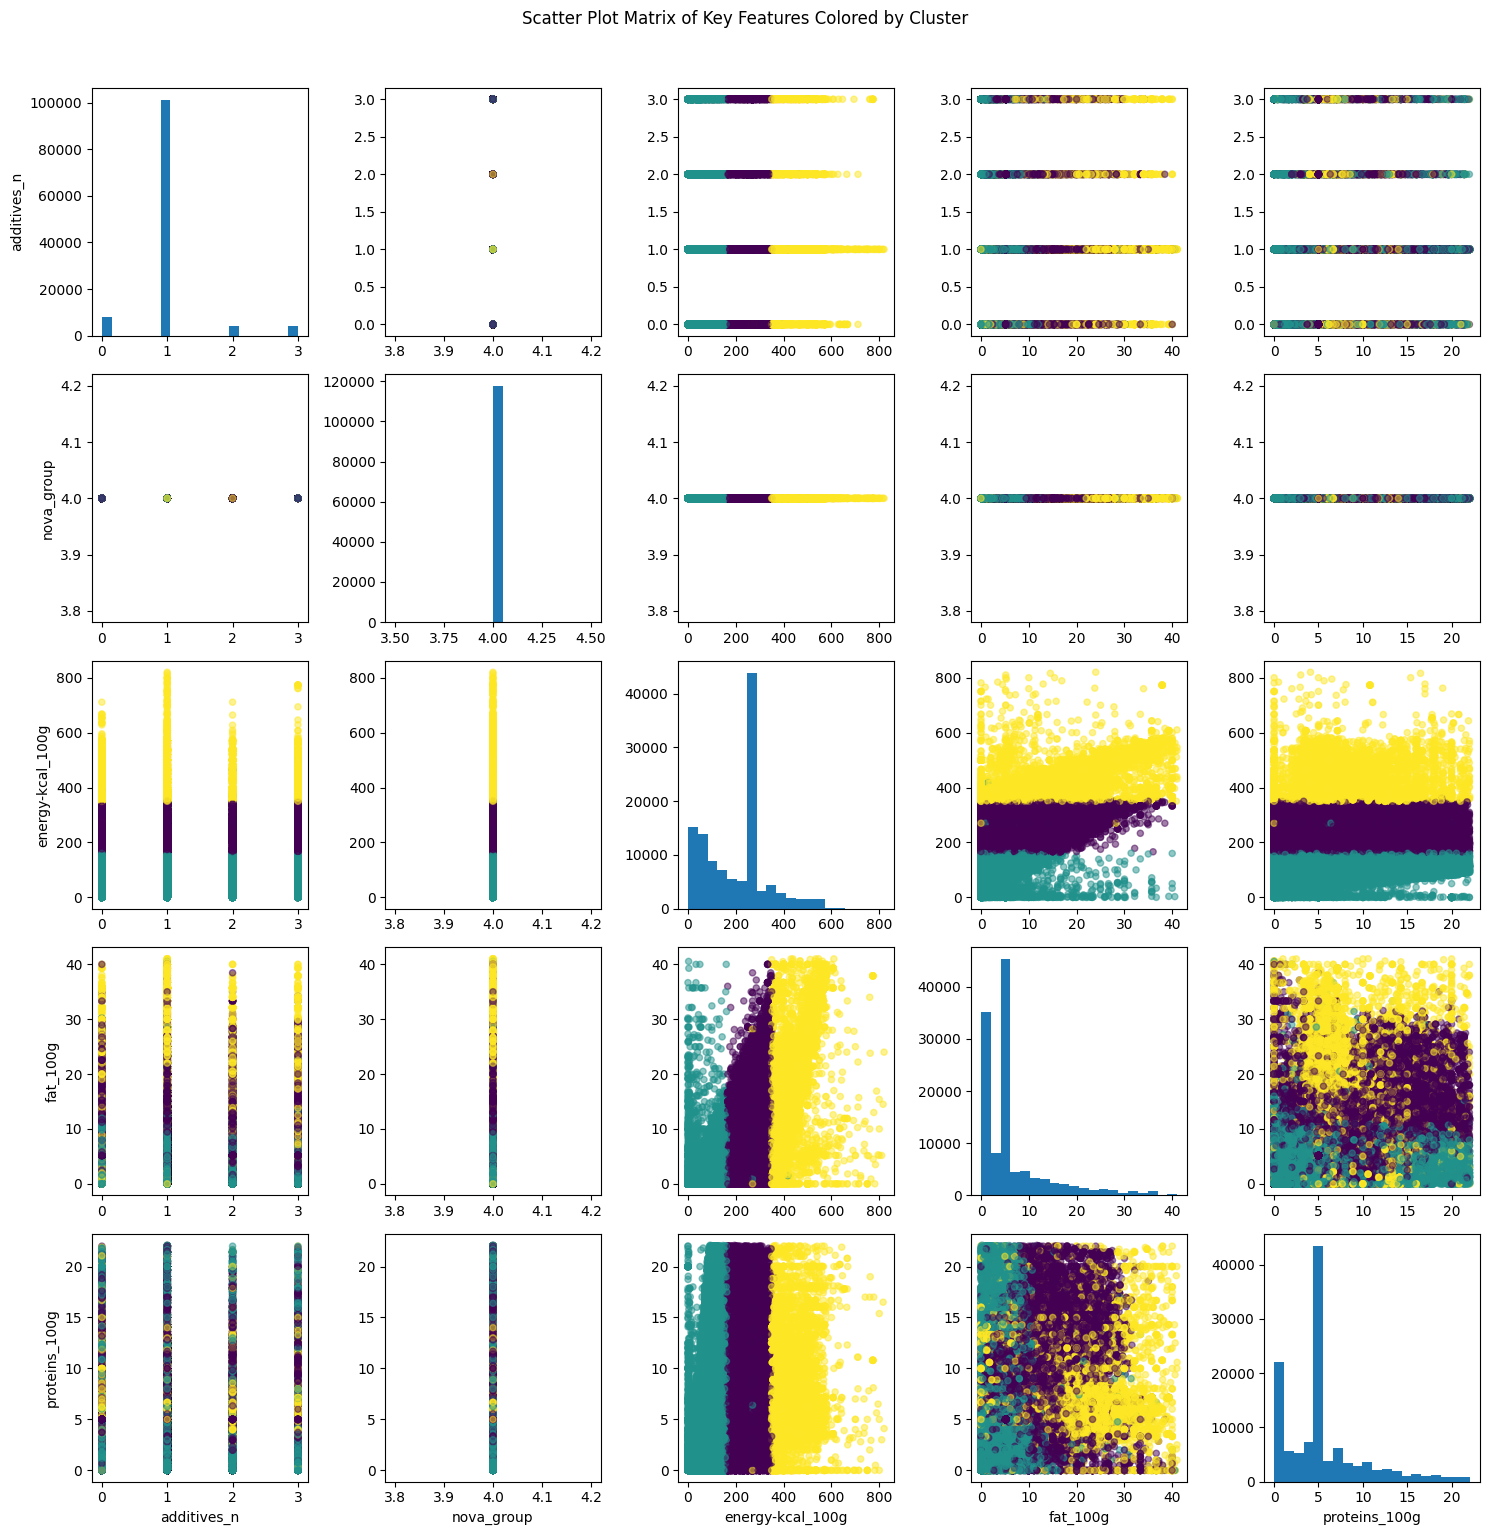

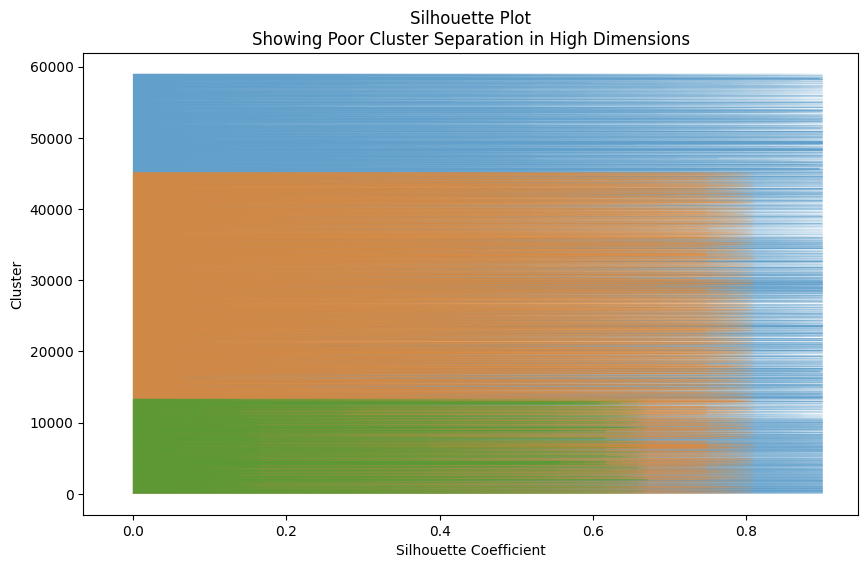

In [13]:
# Make plots
# Print clustering metrics
print("\nClustering metrics:")
print(f"Inertia: {metrics['inertia']:.2f}")
print(f"Number of iterations: {metrics['n_iter']}")
print(f"Silhouette score: {metrics['silhouette']:.3f}")

# Analyze cluster characteristics
print("\nAnalyzing cluster characteristics...")
# Analyze cluster characteristics
cluster_means = analyze_clusters(df_cleaned.values, labels, feature_names=df_cleaned.columns.tolist())

# Plot cluster sizes to see distribution
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=optimal_k, rwidth=0.8)
plt.title('Distribution of Points Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.show()

# Create scatter plot matrix for a few key features to show high dimensionality challenges
key_features = ['additives_n', 'nova_group', 'energy-kcal_100g', 'fat_100g', 'proteins_100g']
fig, axes = plt.subplots(len(key_features), len(key_features), figsize=(15, 15))
fig.suptitle('Scatter Plot Matrix of Key Features Colored by Cluster', y=1.02)

for i, feature1 in enumerate(key_features):
    for j, feature2 in enumerate(key_features):
        ax = axes[i, j]
        if i != j:
            scatter = ax.scatter(df_cleaned[feature2], df_cleaned[feature1], 
                               c=labels, cmap='viridis', alpha=0.5, s=20)
        else:
            ax.hist(df_cleaned[feature1], bins=20)
        if i == len(key_features)-1:
            ax.set_xlabel(feature2)
        if j == 0:
            ax.set_ylabel(feature1)
            
plt.tight_layout()
plt.show()

# Calculate and plot silhouette scores for each cluster
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(df_cleaned.values, labels)

plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    y_lower = 10
    plt.fill_betweenx(np.arange(y_lower, y_lower + len(cluster_silhouette_vals)),
                      0, cluster_silhouette_vals,
                      alpha=0.7)
    y_lower += len(cluster_silhouette_vals) + 10

plt.title('Silhouette Plot\nShowing Poor Cluster Separation in High Dimensions')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.show()

c:\Users\jaech\miniconda3\envs\clustering-openfoodfacts\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jaech\miniconda3\envs\clustering-openfoodfacts\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaech\miniconda3\envs\clustering-openfoodfacts\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\jaech\miniconda3\envs\clustering-openfoodfacts\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


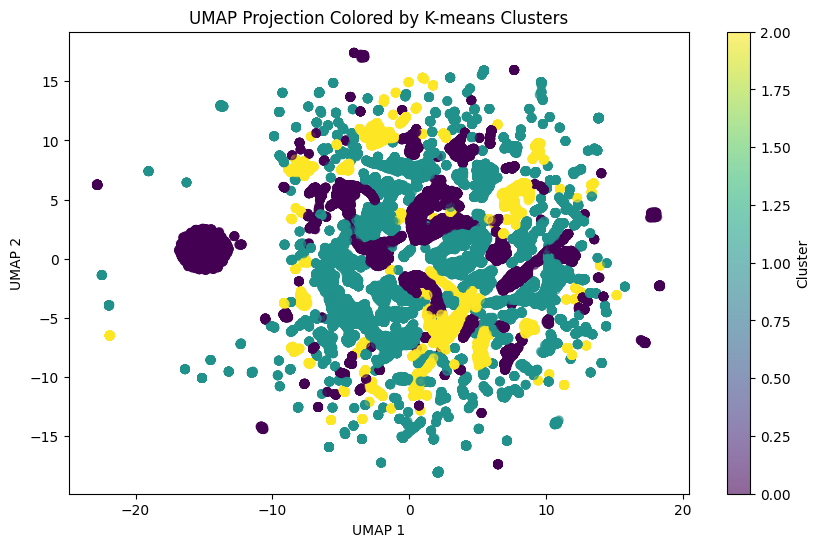

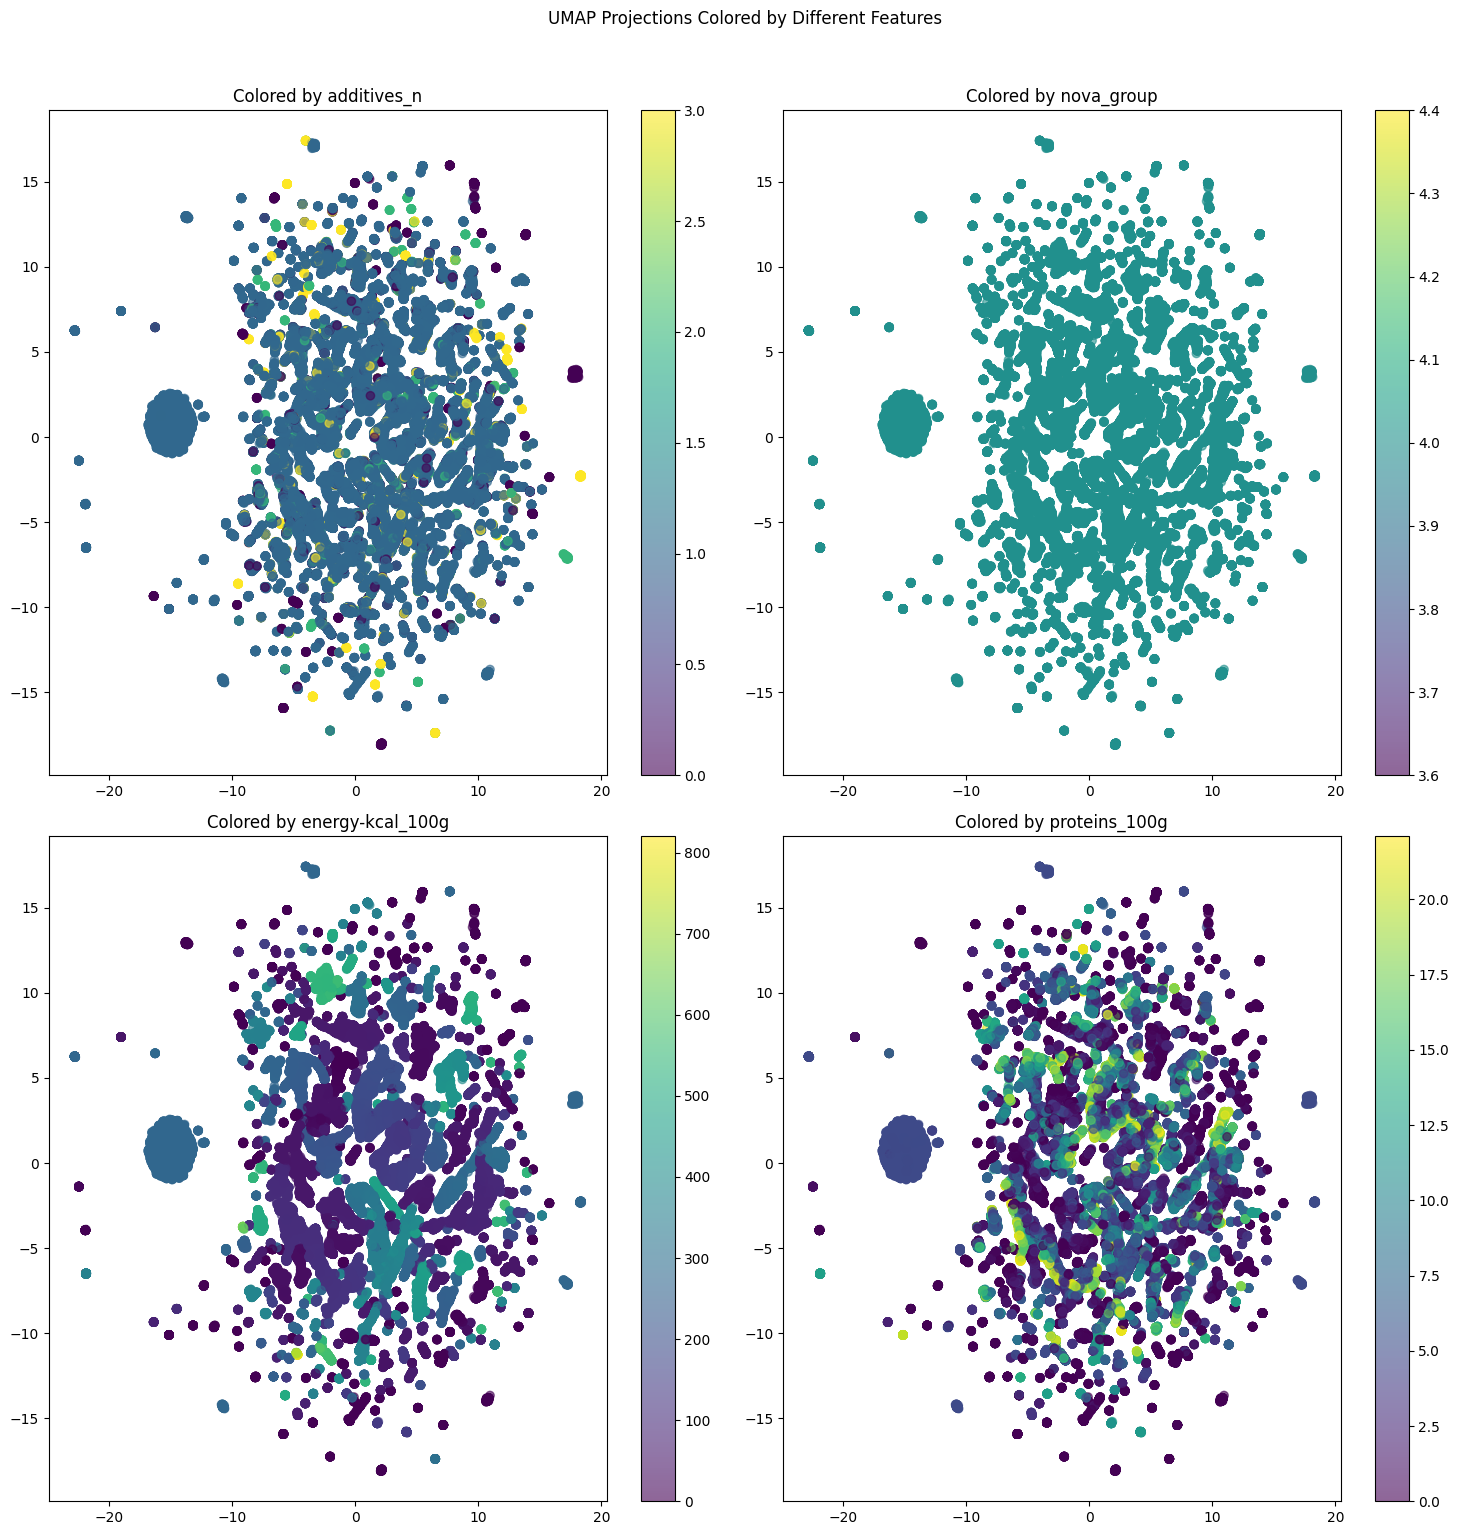

In [14]:
# Import UMAP for dimensionality reduction
from umap import UMAP

# Create and fit UMAP model
umap_model = UMAP(n_components=2, random_state=42)
umap_data = umap_model.fit_transform(df_cleaned.values)

# Plot UMAP results colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(label='Cluster')
plt.title('UMAP Projection Colored by K-means Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Plot UMAP with key features
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('UMAP Projections Colored by Different Features', y=1.02)

features_to_plot = ['additives_n', 'nova_group', 'energy-kcal_100g', 'proteins_100g']
for idx, feature in enumerate(features_to_plot):
    i, j = idx // 2, idx % 2
    scatter = axes[i,j].scatter(umap_data[:, 0], umap_data[:, 1], 
                               c=df_cleaned[feature], cmap='viridis', alpha=0.6)
    axes[i,j].set_title(f'Colored by {feature}')
    plt.colorbar(scatter, ax=axes[i,j])
    
plt.tight_layout()
plt.show()

#### - HDBSCAN

In [13]:
# Perform HDBSCAN clustering with memory constraints
clusterer, labels, metrics = hdbscan_clustering(
    df_scaled.values,
    max_memory_mb=1000,  # Adjust based on your system's memory
    batch_size=10000     # Adjust based on your dataset size
)

if clusterer is not None:
    # Print clustering metrics
    print("\nClustering metrics:")
    print(f"Number of clusters: {metrics['n_clusters']}")
    print(f"Noise ratio: {metrics['noise_ratio']:.2%}")
    print(f"Silhouette score: {metrics['silhouette']:.3f}")

    # Analyze cluster characteristics
    cluster_means = analyze_clusters(df_scaled.values, labels, feature_names=df_scaled.columns.tolist())

    # Plot cluster membership probabilities
    plot_cluster_probabilities(clusterer, df_scaled.values)

TypeError: hdbscan_clustering() got an unexpected keyword argument 'max_memory_mb'

#### - Autoencoders

In [ ]:
# Autoencoders
# Take a sample of your data
sample_size = 10000
df_sample = df_cleaned.sample(n=sample_size, random_state=42)

# Analyze different encoding dimensions
analyze_encoding_dimensions(
    data=df_sample.values,
    max_dim=10,  # Test dimensions from 1 to 10
    title="Encoding Dimension Analysis for Food Products"
)

In [ ]:
# After running the autoencoder
encoder, encoded_data, reconstructed_data, metrics = autoencoder_clustering(
    data=df_sample.values,
    encoding_dim=5
)

plot_autoencoder_advanced_analysis(
    encoded_data=encoded_data,
    original_data=df_sample.values,
    reconstructed_data=reconstructed_data,
    feature_names=df_sample.columns.tolist(),
    title="Advanced Autoencoder Analysis of Food Products"
)

kmeans, labels, kmeans_metrics = kmeans_clustering(encoded_data)

### Cluster evaluation and comparison

In [24]:
# Compare clustering results using metrics (Silhouette score, Calinski-Harabasz index, Davies-Bouldin index)

In [25]:
# Visualize cluster comparisons (word clouds, ...)

In [26]:
# Analyse cluster characteristics and interpret results

### Visualization and Insights

In [27]:
# Various visualizations (cluster distribution plots, feature importance within clusters, pairplots with key features, heatmaps of cluster characteristics)


In [28]:
# Generate insights about food product groupings

In [29]:
# Indentify patterns and trends in the clusters

### Conclusions and recommendations

In [30]:
# Summarize findings


In [31]:
# Compare strengths and weaknesses of different clustering methods


In [32]:
# Provide recommendations for practical applications


In [33]:
#Suggest potential areas for futher analysis